# Processing of Big Data - creating using gaussian distribution from file 30_large swap file

## Featurization function 

In [24]:
from ase.io import read,write
import pymatgen
from pymatgen.analysis.local_env import VoronoiNN
from scipy.spatial import Voronoi, SphericalVoronoi
from pymatgen.io.ase import AseAtomsAdaptor
import os
import pickle
import uuid
import json
from collections import OrderedDict, Iterable, Mapping
from multiprocess import Pool
import numpy as np
import gc
import tqdm
import ase.io
from ase import Atoms
from ase.constraints import FixAtoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable

def fingerprint_atoms_2(atoms):
    '''
    This function is used to fingerprint an adslabs atoms object, where the "fingerprint" is a
    dictionary of properties that we believe may be adsorption motifs.
    Inputs:
        atoms   Atoms object to fingerprint. The slab atoms must be tagged with 0 and
                adsorbate atoms must be tagged with non-zero integers. This function also
                assumes that the first atom in each adsorbate is the binding atom (e.g.,
                of all atoms with tag==1, the first atom is the binding; the same goes for
                tag==2 and tag==3 etc.).
    '''
#     # Remove the adsorbate(s) while finding the binding position(s)
#     atoms, binding_positions = remove_adsorbate(atoms)
#     # Add Uranium atoms at each of the binding sites so that we can use them for fingerprinting.
#     for tag in binding_positions:
#         atoms += Atoms('U', positions=[binding_positions[tag]])

    # Turn the atoms into a pymatgen structure object so that we can use the VCF to find
    # the coordinated sites.
    struct = AseAtomsAdaptor.get_structure(atoms)

    #Test to see if the central atom is entirely on it's own, if so it is not coordinated, so skip the voronoi bit
    # which would throw a QHULL error
    num_cutoff_neighbors = [site[0] for site in enumerate(struct) if 0.1 < struct[len(atoms)-1].distance(site[1]) < 7.0]
    if len(num_cutoff_neighbors) == 0:
        return {'coordination': '',
                'neighborcoord': '',
                'natoms': len(atoms),
                'nextnearestcoordination': ''}

    vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=10)
    vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=10)
    try:
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    except ValueError:
        vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=40)
        vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=40)
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms = [atom_data['site'] for atom_data in coordinated_atoms_data]
    # Create a list of symbols of the coordinations, remove uranium from the list, and
    # then turn the list into a single, human-readable string.
    coordinated_symbols = map(lambda x: x.species_string, coordinated_atoms)
    coordinated_symbols = [a for a in coordinated_symbols if a not in ['U']]
    coordination = '-'.join(sorted(coordinated_symbols))

    # Make a [list] of human-readable coordination sites [unicode] for all of the slab atoms
    # that are coordinated to the adsorbate, "neighborcoord"
    neighborcoord = []
    for i in coordinated_atoms:
        # [int] that yields the slab+ads system's atomic index for the 1st-tier-coordinated atom
        neighborind = [site[0] for site in enumerate(struct) if i.distance(site[1]) < 0.1][0]
        # [list] of PyMatGen [periodic site class]es for each of the atoms that are coordinated
        # with the adsorbate
        coord_data = vnn_loose.get_nn_info(struct, neighborind)
        coord = [atom_data['site'] for atom_data in coord_data]
        # The elemental symbols for all of the 2nd-tier-coordinated atoms in a [list] of
        # [unicode] objects
        coord_symbols = map(lambda x: x.species_string, coord)
        # Take out atoms that we assume are not part of the slab
        coord_symbols = [a for a in coord_symbols if a not in ['U']]
        # Sort the list of 2nd-tier-coordinated atoms to induce consistency
        coord_symbols.sort()
        # Turn the [list] of [unicode] values into a single [unicode]
        neighborcoord.append(i.species_string+':'+'-'.join(coord_symbols))

    # [list] of PyMatGen [periodic site class]es for each of the atoms that are
    # coordinated with the adsorbate
    coordinated_atoms_nextnearest_data = vnn_loose.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms_nextnearest = [atom_data['site'] for atom_data in coordinated_atoms_nextnearest_data]
    # The elemental symbols for all of the coordinated atoms in a [list] of [unicode] objects
    coordinated_symbols_nextnearest = map(lambda x: x.species_string,
                                          coordinated_atoms_nextnearest)
    # Take out atoms that we assume are not part of the slab
    coordinated_symbols_nextnearest = [a for a in coordinated_symbols_nextnearest
                                       if a not in ['U']]
    # Turn the [list] of [unicode] values into a single [unicode]
    coordination_nextnearest = '-'.join(sorted(coordinated_symbols_nextnearest))

    # Return a dictionary with each of the fingerprints. Any key/value pair can be added here
    # and will propagate up the chain
    return {'coordination': coordination,
            'neighborcoord': neighborcoord,
            'natoms': len(atoms),
            'nextnearestcoordination': coordination_nextnearest}

def nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    C=neighbors['coordination']    
    return C.count(atom_type)

def next_nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    N=neighbors['neighborcoord']
    NN=neighbors['nextnearestcoordination']
    N_count=0
    for i in range(len(N)):
        s=N[i]
        sub_s=s[s.index(':') + len(':'):]
        N_count+=sub_s.count(atom_type)
    return N_count

# Create Gaussian distributions and write to xlsx
def ret_Gaussian(mu,sigma,N):
    s = np.random.normal(mu, sigma, N)
    return s


def featurize_new(atoms):
    a=fingerprint_atoms_2(atoms)
    C=a['coordination']
    N=a['neighborcoord']
    NN=a['nextnearestcoordination']
    neighbor_types=['S','Co', 'Ti', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    atom_number=np.array([16,27,22,29,25,42,23,44,21])
    chi=np.array([2.58,1.88,1.54,1.92,1.90,1.55,2.16,1.63,2.2,1.36])

    std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])
    feature_vec=np.zeros((3,2*len(neighbor_types)))
    for i in range(len(neighbor_types)):
        if nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i]=(np.array([atom_number[i],chi[i],nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i]=(np.array([0,0,0])).T
    for i in range(len(neighbor_types)):
        if next_nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i+len(neighbor_types)]=(np.array([atom_number[i],chi[i],next_nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i+len(neighbor_types)]=(np.array([0,0,0])).T

    return feature_vec


## Loading big data saved in location 

In [25]:
## Big Data
## Fetching DGOH data all sulfide classes

import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable
comp = ['CoS','CuS','MnS','MoS','RuS','ScS','TiS','VS']


####################################################
#loading all file names 
def find_xyz_filenames( path_to_dir, suffix=".xyz" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

path='newdata_complete'
CoS_filenames = find_xyz_filenames(path+'/CoS')
CuS_filenames = find_xyz_filenames(path+'/CuS')
MnS_filenames = find_xyz_filenames(path+'/MnS')
MoS_filenames = find_xyz_filenames(path+'/MoS')
RuS_filenames = find_xyz_filenames(path+'/RuS')
ScS_filenames = find_xyz_filenames(path+'/ScS')
TiS_filenames = find_xyz_filenames(path+'/TiS')
VS_filenames = find_xyz_filenames(path+'/VS')


#####################################################
#loading the excel file
def find_xlsx_filenames( path_to_dir, suffix=".xlsx" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

xlsx_filenames = find_xlsx_filenames('data')



######################################################
#loading xlsx data
path ='data/'+xlsx_filenames[0]

##reading the data from each sheet
df = pd.read_excel(path,sheet_name=0)
delta_g_CoS = df[df.columns[0]]
ads_CoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=1)
delta_g_CuS = df[df.columns[0]]
ads_CuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=2)
delta_g_MnS = df[df.columns[0]]
ads_MnS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=3)
delta_g_TiS = df[df.columns[0]]
ads_TiS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=4)
delta_g_RuS = df[df.columns[0]]
ads_RuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=5)
delta_g_MoS = df[df.columns[0]]
ads_MoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=6)
delta_g_ScS = df[df.columns[0]]
ads_ScS = df[df.columns[1]]


df = pd.read_excel(path,sheet_name=7)
delta_g_VS = df[df.columns[0]]
ads_VS = df[df.columns[1]]

std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])

N=30
j=0
vec_Co=np.zeros((len(delta_g_CoS),N))
for i in range(len(delta_g_CoS)):
    vec_Co[i,:]=(ret_Gaussian(delta_g_CoS[i],std_GOH[j],N)).T
j=j+1

vec_Cu=np.zeros((len(delta_g_CuS),N))
for i in range(len(delta_g_CuS)):
    vec_Cu[i,:]=ret_Gaussian(delta_g_CuS[i],std_GOH[j],N)
j=j+1

vec_Mn=np.zeros((len(delta_g_MnS),N))
for i in range(len(delta_g_MnS)):
    vec_Mn[i,:]=ret_Gaussian(delta_g_MnS[i],std_GOH[j],N)
j=j+1

vec_Ti=np.zeros((len(delta_g_TiS),N))
for i in range(len(delta_g_TiS)):
    vec_Ti[i,:]=ret_Gaussian(delta_g_TiS[i],std_GOH[j],N)
j=j+1

vec_Ru=np.zeros((len(delta_g_RuS),N))
for i in range(len(delta_g_RuS)):
    vec_Ru[i,:]=ret_Gaussian(delta_g_RuS[i],std_GOH[j],N)
j=j+1

vec_Mo=np.zeros((len(delta_g_MoS),N))
for i in range(len(delta_g_MoS)):
    vec_Mo[i,:]=ret_Gaussian(delta_g_MoS[i],std_GOH[j],N)
j=j+1

vec_Sc=np.zeros((len(delta_g_ScS),N))
for i in range(len(delta_g_ScS)):
    vec_Sc[i,:]=ret_Gaussian(delta_g_ScS[i],std_GOH[j],N)
j=j+1

vec_V=np.zeros((len(delta_g_VS),N))
for i in range(len(delta_g_VS)):
    vec_V[i,:]=ret_Gaussian(delta_g_VS[i],std_GOH[j],N)
j=j+1

vec_Co_reshape=np.reshape(vec_Co.T,(vec_Co.T.size,1))
vec_Cu_reshape=np.reshape(vec_Cu.T,(vec_Cu.T.size,1))
vec_Mn_reshape=np.reshape(vec_Mn.T,(vec_Mn.T.size,1))
vec_Ti_reshape=np.reshape(vec_Ti.T,(vec_Ti.T.size,1))
vec_Ru_reshape=np.reshape(vec_Ru.T,(vec_Ru.T.size,1))
vec_Mo_reshape=np.reshape(vec_Mo.T,(vec_Mo.T.size,1))
vec_Sc_reshape=np.reshape(vec_Sc.T,(vec_Sc.T.size,1))
vec_V_reshape=np.reshape(vec_V.T,(vec_V.T.size,1))
                         
                          
DGOH=np.hstack((vec_Co_reshape.T,vec_Cu_reshape.T,vec_Mn_reshape.T,vec_Ti_reshape.T,vec_Ru_reshape.T,vec_Mo_reshape.T,vec_Sc_reshape.T,vec_V_reshape.T))
print(DGOH.shape)


(1, 1470)


## Create of feature matrix using the input data

In [26]:
## Building feature vector from all sulfides


def fetchdata(filenames,stringname,size):
    neighbor_types=['S','Co', 'Cr', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    featureVectorStack=np.zeros((3,2*len(neighbor_types),size))
    path='newdata_complete'
    r = 0
    for i in range(0,len(filenames)):
        atoms=read(path+'/'+stringname+'/'+str(i)+'.xyz')
        featureVectorStack[:,:,i]=featurize_new(atoms)
    return featureVectorStack
        
       
FV1=fetchdata(CoS_filenames,'CoS',len(delta_g_CoS)*N)  
print('Co done')
FV2=fetchdata(CuS_filenames,'CuS',len(delta_g_CuS)*N)  
print('Cu done')
FV3=fetchdata(MnS_filenames,'MnS',len(delta_g_MnS)*N)  
print('Mn done')
FV4=fetchdata(TiS_filenames,'TiS',len(delta_g_TiS)*N)
print('Ti done')
FV5=fetchdata(RuS_filenames,'RuS',len(delta_g_RuS)*N)  
print('Ru done')
FV6=fetchdata(MoS_filenames,'MoS',len(delta_g_MoS)*N)  
print('Mo done')
FV7=fetchdata(ScS_filenames,'ScS',len(delta_g_ScS)*N)  
print('Sc done')
FV8=fetchdata(VS_filenames,'VS',len(delta_g_VS)*N)  
print('V done')
FV=np.dstack((FV1,FV2,FV3,FV4,FV5,FV6,FV7,FV8))




Co done
Cu done
Mn done
Ti done
Ru done
Mo done
Sc done
V done


In [19]:
import numpy as np


file = open(“FV_shape_large.txt”,”w”) 
file.write(FV_shape) 


print(FV.shape)

a=np.array([[1,2,3],[4,5,6]])
b=np.reshape(a,(a.size,1))
print(b)
c=np.reshape(a.T,(a.size,1))
print(c)


SyntaxError: invalid character in identifier (<ipython-input-19-5d5eb92a785a>, line 4)

In [146]:
print(len(CoS_filenames))

r,c,d=FV.shape
FV_reshape = FV.reshape((r*c,d))

print (DGOH.T.shape)
print (FV[1,:,:])


210
(1470, 1)
[[2.58 2.58 0.   ... 0.   0.   0.  ]
 [0.   0.   1.88 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 2.16 2.16 2.16]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [147]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(FV_reshape.T))
dg = np.array(DGOH.T)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

print (x.shape)
print (y.shape)

#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 49



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),nn.Linear(n_h2, n_h3),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


torch.Size([1470, 54])
torch.Size([1470, 1])
epoch:  0  loss:  1.8615591526031494
epoch:  1000  loss:  0.08727176487445831
epoch:  2000  loss:  0.08625168353319168
epoch:  3000  loss:  0.08633218705654144
epoch:  4000  loss:  0.08642829209566116
epoch:  5000  loss:  0.08650456368923187
epoch:  6000  loss:  0.08834989368915558
epoch:  7000  loss:  0.08628697693347931
epoch:  8000  loss:  0.08719723671674728
epoch:  9000  loss:  0.0875597670674324


[[ 0.20000277]
 [ 0.40003183]
 [ 0.7709515 ]
 ...
 [-1.0425292 ]
 [-0.9152414 ]
 [-1.4383539 ]]
[[ 0.5062749 ]
 [ 0.21843934]
 [ 0.8784252 ]
 ...
 [-1.0732963 ]
 [-1.0732963 ]
 [-0.86544544]]
0.29385376


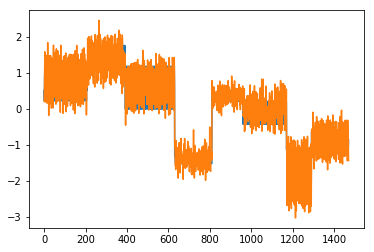

In [148]:


y1_pred = y_pred.detach().numpy()
y1  = y.detach().numpy()

print (y1)
print (y1_pred)

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [149]:
print (optimizer.score)

AttributeError: 'Adam' object has no attribute 'score'

In [ ]:
(optimizer.score(np.asmatrix(FV_reshape.T), DGOH))

In [150]:
import sklearn.model_selection
from tpot import TPOTRegressor
from sklearn.metrics.scorer import make_scorer


############################
#parameter descriptions:
#generations = how many iterations to go through in optimizer
#population_size = number of individuals to retain in algrotihm every generation (will work better with more, but take longer)
#random_state = random seed going into optimizer. Should get the same result if we use the same data and seed
#changing seed may affect result
#verbosity = how much TPOT prints out while it's running, integer value 0-3. 0=prints nothing, 3=prints everything
###############################

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return np.std(y_pred- y_true)

# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=False)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
#                       scoring=my_custom_scorer)



optimizer = TPOTRegressor(generations=20, population_size=20, random_state=99, verbosity=2,periodic_checkpoint_folder="tpot_results.txt" ,
                      scoring=my_custom_scorer)


print (FV_reshape.shape)
print (DGOH.shape)

#fit to training data
optimizer.fit(FV_reshape.T, DGOH.T)

(54, 1470)
(1, 1470)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: -0.4499752341445462
Generation 2 - Current best internal CV score: -0.4499752341445462
Generation 3 - Current best internal CV score: -0.4466954217530376
Generation 4 - Current best internal CV score: -0.4092331815578185
Generation 5 - Current best internal CV score: -0.4092331815578185
Generation 6 - Current best internal CV score: -0.4092331815578185
Generation 7 - Current best internal CV score: -0.4092331815578185
Generation 8 - Current best internal CV score: -0.4092331815578185
Generation 9 - Current best internal CV score: -0.3944141823688155
Generation 10 - Current best internal CV score: -0.3944141823688155
Generation 11 - Current best internal CV score: -0.3944141823688155
Generation 12 - Current best internal CV score: -0.3792671144631905
Generation 13 - Current best internal CV score: -0.3792671144631905
Generation 14 - Current best internal CV score: -0.37836088677526025
Generation 15 - Current best internal CV score: -0.37836

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=20,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder='tpot_results.txt', population_size=20,
       random_state=99,
       scoring=make_scorer(my_custom_accuracy, greater_is_better=False),
       subsample=1.0, use_dask=False, verbosity=2, warm_start=False)

In [151]:
result = optimizer.predict(np.asmatrix(FV_reshape.T))

print (np.std(result-DGOH))

0.23396482462249996


In [152]:
#####with test train split

In [153]:
print(len(CoS_filenames))

r,c,d=FV.shape


print (r)
print (FV.shape)
print(FV[2,:,:])
FV_reshape = FV.reshape((r*c,d))
print (FV_reshape.shape)

print (DGOH.T.shape)

210
3
(3, 18, 1470)
[[3. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 3. 3. 6.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(54, 1470)
(1470, 1)


In [154]:
## TPOT implementation with train and test split 
### The standard deveation is calculcuated on Test Set 

In [155]:
###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)




In [185]:


import sklearn.model_selection
from tpot import TPOTRegressor
from sklearn.metrics.scorer import make_scorer


############################
#parameter descriptions:
#generations = how many iterations to go through in optimizer
#population_size = number of individuals to retain in algrotihm every generation (will work better with more, but take longer)
#random_state = random seed going into optimizer. Should get the same result if we use the same data and seed
#changing seed may affect result
#verbosity = how much TPOT prints out while it's running, integer value 0-3. 0=prints nothing, 3=prints everything
###############################

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return np.std(y_pred- y_true)

# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=False)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
#                       scoring=my_custom_scorer)



optimizer = TPOTRegressor(generations=20, population_size=20, random_state=99, verbosity=2,periodic_checkpoint_folder="tpot_results.txt" ,
                      scoring=my_custom_scorer)

#fit to training data
optimizer.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: -0.2392510712410915
Generation 2 - Current best internal CV score: -0.2392510712410915
Generation 3 - Current best internal CV score: -0.2392510712410915
Generation 4 - Current best internal CV score: -0.23915313900190438
Generation 5 - Current best internal CV score: -0.23907294479029678
Generation 6 - Current best internal CV score: -0.23899298093471866
Generation 7 - Current best internal CV score: -0.23899298093471866
Generation 8 - Current best internal CV score: -0.23899298093471866
Generation 9 - Current best internal CV score: -0.23899298093471866
Generation 10 - Current best internal CV score: -0.23899298093471866
Generation 11 - Current best internal CV score: -0.23868627458756775
Generation 12 - Current best internal CV score: -0.23868627458756775
Generation 13 - Current best internal CV score: -0.23868627458756775
Generation 14 - Current best internal CV score: -0.23868627458756775
Generation 15 - Current best internal CV score

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=20,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder='tpot_results.txt', population_size=20,
       random_state=99,
       scoring=make_scorer(my_custom_accuracy, greater_is_better=False),
       subsample=1.0, use_dask=False, verbosity=2, warm_start=False)

In [186]:
result = optimizer.predict(X_test)

print (np.std(result-y_test))

1.4772473926976708


In [158]:
###Neural network with test train split

In [187]:
print(len(CoS_filenames))

r,c,d=FV.shape


print (r)
print (FV.shape)
print(FV[2,:,:])
FV_reshape = FV.reshape((r*c,d))
print (FV_reshape.shape)

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

210
3
(3, 18, 1470)
[[ 0.26734023  0.45725703 -0.33590996 ...  0.          0.
   0.        ]
 [-0.33450965 -0.33951224  0.33380161 ...  0.          0.
   0.        ]
 [-0.33450965 -0.33951224 -0.33590996 ...  0.          0.
   0.        ]
 ...
 [-0.33450965 -0.33951224 -0.33590996 ...  3.          3.
   6.        ]
 [-0.33450965 -0.33951224 -0.33590996 ...  0.          0.
   0.        ]
 [-0.33450965 -0.33951224 -0.33590996 ...  0.          0.
   0.        ]]
(54, 1470)
(1470, 1)


In [188]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  2.7103216648101807
epoch:  1000  loss:  0.095857635140419
epoch:  2000  loss:  0.10053405165672302
epoch:  3000  loss:  0.08933231979608536
epoch:  4000  loss:  0.08911154419183731
epoch:  5000  loss:  0.08871530741453171
epoch:  6000  loss:  0.08851945400238037
epoch:  7000  loss:  0.08838611096143723
epoch:  8000  loss:  0.09037498384714127
epoch:  9000  loss:  0.08919703960418701


0.3030241213044849


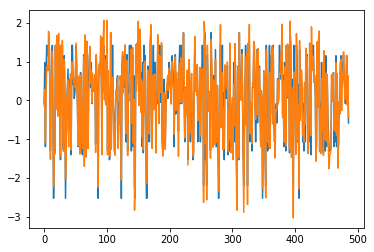

In [189]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [190]:
###########Using only coordination number 



r,c,d=FV.shape

print (FV[2,:,:])
FV_coordination = FV[2,:,:]
print (FV_coordination.shape)

###with test train split

X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(FV_coordination.T, DGOH.T, test_size=0.3, random_state=42,shuffle=True)





[[ 0.26734023  0.45725703 -0.33590996 ...  0.          0.
   0.        ]
 [-0.33450965 -0.33951224  0.33380161 ...  0.          0.
   0.        ]
 [-0.33450965 -0.33951224 -0.33590996 ...  0.          0.
   0.        ]
 ...
 [-0.33450965 -0.33951224 -0.33590996 ...  3.          3.
   6.        ]
 [-0.33450965 -0.33951224 -0.33590996 ...  0.          0.
   0.        ]
 [-0.33450965 -0.33951224 -0.33590996 ...  0.          0.
   0.        ]]
(18, 1470)


In [191]:

# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train_co))
dg = np.array(y_train_co)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 18, 18,16,18, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  3.6291773319244385
epoch:  1000  loss:  0.27096471190452576
epoch:  2000  loss:  0.27096474170684814
epoch:  3000  loss:  0.27361974120140076
epoch:  4000  loss:  0.27096474170684814
epoch:  5000  loss:  0.27096474170684814
epoch:  6000  loss:  0.27096471190452576
epoch:  7000  loss:  0.27097585797309875
epoch:  8000  loss:  0.271258682012558
epoch:  9000  loss:  0.27098986506462097


In [192]:
test_data = torch.FloatTensor(np.array(X_test_co))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test_co

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

0.5122673600236552


In [195]:
#######only one compound at a time CoS


###considering all the features



r,c,d=FV1.shape


FV1_reshape = FV1.reshape((r*c,d))

###with test train split

X_train_Cob, X_test_Cob, y_train_Cob, y_test_Cob = train_test_split(FV1_reshape.T, vec_Co_reshape, test_size=0.2, random_state=42,shuffle=True)


print (X_train_Cob.shape)

(168, 54)


In [196]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train_Cob))
dg = np.array(y_train_Cob)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h2, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  2.2772765159606934
epoch:  1000  loss:  0.047928277403116226
epoch:  2000  loss:  0.047928277403116226
epoch:  3000  loss:  0.04793064668774605
epoch:  4000  loss:  0.04809525981545448
epoch:  5000  loss:  0.05351264402270317
epoch:  6000  loss:  0.05385475233197212
epoch:  7000  loss:  0.04836314544081688
epoch:  8000  loss:  0.04898040369153023
epoch:  9000  loss:  0.04854470118880272
epoch:  10000  loss:  0.04792867600917816
epoch:  11000  loss:  0.04792829602956772
epoch:  12000  loss:  0.047928277403116226
epoch:  13000  loss:  0.047928277403116226
epoch:  14000  loss:  0.047928277403116226
epoch:  15000  loss:  0.058464519679546356
epoch:  16000  loss:  0.047928277403116226
epoch:  17000  loss:  0.047928277403116226
epoch:  18000  loss:  0.047928277403116226
epoch:  19000  loss:  0.047979872673749924


0.2243438465386706


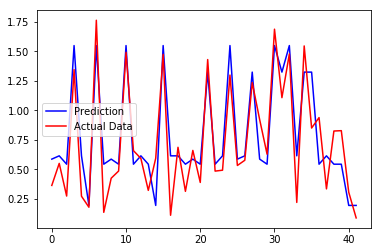

In [197]:
test_data = torch.FloatTensor(np.array(X_test_Cob))

x_test =  Variable(test_data)
y_pred_test = model(test_data)

y1_pred = y_pred_test.detach().numpy()
y1  = y_test_Cob

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])
print (np.std(y1_pred-y1))

0.21896803835982423


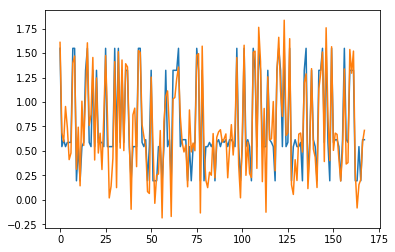

In [198]:
##train std deviation for the same data

train_data = torch.FloatTensor(np.array(X_train_Cob))

x_train =  Variable(train_data)
y_pred_train = model(train_data)

y1_pred = y_pred_train.detach().numpy()
y1  = y_train_Cob

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [202]:
###data preprocessing --- complete data -------no use 

print(len(CoS_filenames))

r,c,d=FV.shape


print (r)
print (FV.shape)
FV_reshape = FV.reshape((r*c,d))
for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])

print (FV_reshape.shape)

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

210
3
(3, 18, 1470)
(54, 1470)
(1470, 1)


In [203]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  2.485501527786255
epoch:  1000  loss:  0.09324465692043304
epoch:  2000  loss:  0.09029994904994965
epoch:  3000  loss:  0.0892631858587265
epoch:  4000  loss:  0.09712054580450058
epoch:  5000  loss:  0.0886264368891716
epoch:  6000  loss:  0.08918406069278717
epoch:  7000  loss:  0.08907376229763031
epoch:  8000  loss:  0.08899717777967453
epoch:  9000  loss:  0.0889170840382576


The standard deveation is:
0.30280710745113154


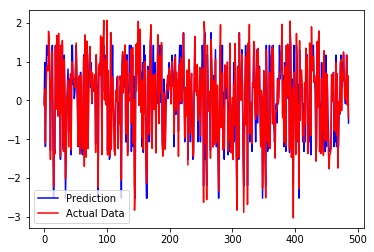

In [205]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])
print ('The standard deveation is:')
print (np.std(y1_pred-y1))